# Encoder vs Decoder Stage Latency Analysis

인코더와 디코더 스테이지별 latency 비교

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

from models import JeongWonNet, CMUNeXt

print(f"PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/home/sanghyuck/anaconda3/envs/Skin_Lesion_Seg/lib/python3.8/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


PyTorch: 2.0.1+cu118 | CUDA: True
GPU: NVIDIA GeForce RTX 3090


In [2]:
# 설정
INPUT_SIZE = (3, 256, 256)
NUM_WARMUP = 50
NUM_ITERATIONS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def measure_latency(fn, num_warmup=NUM_WARMUP, num_iterations=NUM_ITERATIONS):
    """함수 실행 시간 측정 (ms) - fn은 인자 없는 lambda로 전달"""
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = fn()

    if DEVICE.type == 'cuda':
        torch.cuda.synchronize()

    times = []
    with torch.no_grad():
        for _ in range(num_iterations):
            if DEVICE.type == 'cuda':
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = fn()
            if DEVICE.type == 'cuda':
                torch.cuda.synchronize()
            end = time.perf_counter()
            times.append((end - start) * 1000)

    return np.mean(times), np.std(times)

print(f"Device: {DEVICE}")
print(f"Input: {INPUT_SIZE} | Warmup: {NUM_WARMUP} | Iterations: {NUM_ITERATIONS}")

Device: cuda
Input: (3, 256, 256) | Warmup: 50 | Iterations: 100


## 1. JeongWonNet Stage Latency

In [3]:
model_jwn = JeongWonNet(num_classes=1, gt_ds=False).to(DEVICE).eval()
x_jwn = torch.randn(1, *INPUT_SIZE).to(DEVICE)

jwn_results = {}

# 각 스테이지 입력 준비
with torch.no_grad():
    e1 = F.max_pool2d(model_jwn.encoder1(x_jwn), 2)
    e2 = F.max_pool2d(model_jwn.encoder2(e1), 2)
    e3 = F.max_pool2d(model_jwn.encoder3(e2), 2)
    e4 = F.max_pool2d(model_jwn.encoder4(e3), 2)
    e5 = F.max_pool2d(model_jwn.encoder5(e4), 2)
    e6 = model_jwn.encoder6(e5)
    d5 = model_jwn.decoder1(e6) + e5
    d4 = F.interpolate(model_jwn.decoder2(d5), scale_factor=2, mode='bilinear', align_corners=True) + e4
    d3 = F.interpolate(model_jwn.decoder3(d4), scale_factor=2, mode='bilinear', align_corners=True) + e3
    d2 = F.interpolate(model_jwn.decoder4(d3), scale_factor=2, mode='bilinear', align_corners=True) + e2
    d1 = F.interpolate(model_jwn.decoder5(d2), scale_factor=2, mode='bilinear', align_corners=True) + e1

# 클로저 변수 캡처를 위해 리스트 사용
enc_inputs = [x_jwn, e1, e2, e3, e4, e5]
dec_inputs = [e6, d5, d4, d3, d2, d1]

print("JeongWonNet Encoder Stages:")
enc_fns = [
    lambda i=0: F.max_pool2d(model_jwn.encoder1(enc_inputs[i]), 2),
    lambda i=1: F.max_pool2d(model_jwn.encoder2(enc_inputs[i]), 2),
    lambda i=2: F.max_pool2d(model_jwn.encoder3(enc_inputs[i]), 2),
    lambda i=3: F.max_pool2d(model_jwn.encoder4(enc_inputs[i]), 2),
    lambda i=4: F.max_pool2d(model_jwn.encoder5(enc_inputs[i]), 2),
    lambda i=5: model_jwn.encoder6(enc_inputs[i]),
]
for name, fn in zip(['Enc1', 'Enc2', 'Enc3', 'Enc4', 'Enc5', 'Enc6'], enc_fns):
    mean, std = measure_latency(fn)
    jwn_results[name] = {'mean': mean, 'std': std}
    print(f"  {name}: {mean:.3f} ± {std:.3f} ms")

print("\nJeongWonNet Decoder Stages:")
dec_fns = [
    lambda i=0: model_jwn.decoder1(dec_inputs[i]),
    lambda i=1: F.interpolate(model_jwn.decoder2(dec_inputs[i]), scale_factor=2, mode='bilinear', align_corners=True),
    lambda i=2: F.interpolate(model_jwn.decoder3(dec_inputs[i]), scale_factor=2, mode='bilinear', align_corners=True),
    lambda i=3: F.interpolate(model_jwn.decoder4(dec_inputs[i]), scale_factor=2, mode='bilinear', align_corners=True),
    lambda i=4: F.interpolate(model_jwn.decoder5(dec_inputs[i]), scale_factor=2, mode='bilinear', align_corners=True),
    lambda i=5: F.interpolate(model_jwn.final(dec_inputs[i]), scale_factor=2, mode='bilinear', align_corners=True),
]
for name, fn in zip(['Dec1', 'Dec2', 'Dec3', 'Dec4', 'Dec5', 'Final'], dec_fns):
    mean, std = measure_latency(fn)
    jwn_results[name] = {'mean': mean, 'std': std}
    print(f"  {name}: {mean:.3f} ± {std:.3f} ms")

del model_jwn, x_jwn, enc_inputs, dec_inputs
del e1, e2, e3, e4, e5, e6, d5, d4, d3, d2, d1
torch.cuda.empty_cache()

JeongWonNet Encoder Stages:
  Enc1: 0.126 ± 0.029 ms
  Enc2: 0.074 ± 0.001 ms
  Enc3: 0.069 ± 0.006 ms
  Enc4: 0.065 ± 0.027 ms
  Enc5: 0.066 ± 0.033 ms
  Enc6: 0.060 ± 0.027 ms

JeongWonNet Decoder Stages:
  Dec1: 0.056 ± 0.006 ms
  Dec2: 0.065 ± 0.003 ms
  Dec3: 0.070 ± 0.027 ms
  Dec4: 0.067 ± 0.008 ms
  Dec5: 0.067 ± 0.028 ms
  Final: 0.018 ± 0.000 ms


## 2. CMUNeXt Stage Latency

In [4]:
model_cmu = CMUNeXt(num_classes=1).to(DEVICE).eval()
x_cmu = torch.randn(1, *INPUT_SIZE).to(DEVICE)

cmu_results = {}

# Encoder 스테이지 입력 준비
with torch.no_grad():
    stem_out = model_cmu.stem(x_cmu)
    x1 = model_cmu.encoder1(stem_out)
    x2 = model_cmu.encoder2(model_cmu.Maxpool(x1))
    x3 = model_cmu.encoder3(model_cmu.Maxpool(x2))
    x4 = model_cmu.encoder4(model_cmu.Maxpool(x3))
    x5 = model_cmu.encoder5(model_cmu.Maxpool(x4))
    # Decoder
    d5_up = model_cmu.Up5(x5)
    d5 = model_cmu.Up_conv5(torch.cat((x4, d5_up), dim=1))
    d4_up = model_cmu.Up4(d5)
    d4 = model_cmu.Up_conv4(torch.cat((x3, d4_up), dim=1))
    d3_up = model_cmu.Up3(d4)
    d3 = model_cmu.Up_conv3(torch.cat((x2, d3_up), dim=1))
    d2_up = model_cmu.Up2(d3)
    d2 = model_cmu.Up_conv2(torch.cat((x1, d2_up), dim=1))

# 입력 저장
cmu_enc_in = [x_cmu, stem_out, x1, x2, x3, x4]
cmu_dec_data = {
    'x5': x5, 'x4': x4, 'x3': x3, 'x2': x2, 'x1': x1,
    'd5_up': d5_up, 'd5': d5, 'd4_up': d4_up, 'd4': d4,
    'd3_up': d3_up, 'd3': d3, 'd2_up': d2_up, 'd2': d2
}

print("CMUNeXt Encoder Stages:")
cmu_enc_fns = [
    lambda: model_cmu.stem(cmu_enc_in[0]),
    lambda: model_cmu.encoder1(cmu_enc_in[1]),
    lambda: model_cmu.encoder2(model_cmu.Maxpool(cmu_enc_in[2])),
    lambda: model_cmu.encoder3(model_cmu.Maxpool(cmu_enc_in[3])),
    lambda: model_cmu.encoder4(model_cmu.Maxpool(cmu_enc_in[4])),
    lambda: model_cmu.encoder5(model_cmu.Maxpool(cmu_enc_in[5])),
]
for name, fn in zip(['Stem', 'Enc1', 'Enc2', 'Enc3', 'Enc4', 'Enc5'], cmu_enc_fns):
    mean, std = measure_latency(fn)
    cmu_results[name] = {'mean': mean, 'std': std}
    print(f"  {name}: {mean:.3f} ± {std:.3f} ms")

print("\nCMUNeXt Decoder Stages:")
cmu_dec_fns = [
    ('Up5', lambda: model_cmu.Up5(cmu_dec_data['x5'])),
    ('UpConv5', lambda: model_cmu.Up_conv5(torch.cat((cmu_dec_data['x4'], cmu_dec_data['d5_up']), dim=1))),
    ('Up4', lambda: model_cmu.Up4(cmu_dec_data['d5'])),
    ('UpConv4', lambda: model_cmu.Up_conv4(torch.cat((cmu_dec_data['x3'], cmu_dec_data['d4_up']), dim=1))),
    ('Up3', lambda: model_cmu.Up3(cmu_dec_data['d4'])),
    ('UpConv3', lambda: model_cmu.Up_conv3(torch.cat((cmu_dec_data['x2'], cmu_dec_data['d3_up']), dim=1))),
    ('Up2', lambda: model_cmu.Up2(cmu_dec_data['d3'])),
    ('UpConv2', lambda: model_cmu.Up_conv2(torch.cat((cmu_dec_data['x1'], cmu_dec_data['d2_up']), dim=1))),
    ('Final', lambda: model_cmu.Conv_1x1(cmu_dec_data['d2'])),
]
for name, fn in cmu_dec_fns:
    mean, std = measure_latency(fn)
    cmu_results[name] = {'mean': mean, 'std': std}
    print(f"  {name}: {mean:.3f} ± {std:.3f} ms")

del model_cmu, x_cmu, cmu_enc_in, cmu_dec_data
torch.cuda.empty_cache()

CMUNeXt Encoder Stages:
  Stem: 0.066 ± 0.030 ms
  Enc1: 0.297 ± 0.035 ms
  Enc2: 0.124 ± 0.035 ms
  Enc3: 0.100 ± 0.007 ms
  Enc4: 0.228 ± 0.029 ms
  Enc5: 0.098 ± 0.002 ms

CMUNeXt Decoder Stages:
  Up5: 0.046 ± 0.029 ms
  UpConv5: 0.076 ± 0.003 ms
  Up4: 0.040 ± 0.021 ms
  UpConv4: 0.081 ± 0.029 ms
  Up3: 0.051 ± 0.003 ms
  UpConv3: 0.154 ± 0.070 ms
  Up2: 0.086 ± 0.018 ms
  UpConv2: 0.340 ± 0.037 ms
  Final: 0.014 ± 0.001 ms


## 3. Summary: Encoder vs Decoder

In [5]:
# JeongWonNet 집계
jwn_enc_keys = ['Enc1', 'Enc2', 'Enc3', 'Enc4', 'Enc5', 'Enc6']
jwn_dec_keys = ['Dec1', 'Dec2', 'Dec3', 'Dec4', 'Dec5', 'Final']

jwn_enc_total = sum(jwn_results[k]['mean'] for k in jwn_enc_keys)
jwn_dec_total = sum(jwn_results[k]['mean'] for k in jwn_dec_keys)
jwn_total = jwn_enc_total + jwn_dec_total

# CMUNeXt 집계
cmu_enc_keys = ['Stem', 'Enc1', 'Enc2', 'Enc3', 'Enc4', 'Enc5']
cmu_dec_keys = ['Up5', 'UpConv5', 'Up4', 'UpConv4', 'Up3', 'UpConv3', 'Up2', 'UpConv2', 'Final']

cmu_enc_total = sum(cmu_results[k]['mean'] for k in cmu_enc_keys)
cmu_dec_total = sum(cmu_results[k]['mean'] for k in cmu_dec_keys)
cmu_total = cmu_enc_total + cmu_dec_total

# Summary table
summary = pd.DataFrame({
    'Model': ['JeongWonNet', 'CMUNeXt'],
    'Encoder (ms)': [jwn_enc_total, cmu_enc_total],
    'Decoder (ms)': [jwn_dec_total, cmu_dec_total],
    'Total (ms)': [jwn_total, cmu_total],
    'Enc %': [jwn_enc_total/jwn_total*100, cmu_enc_total/cmu_total*100],
    'Dec %': [jwn_dec_total/jwn_total*100, cmu_dec_total/cmu_total*100],
})

print("="*60)
print("Encoder vs Decoder Latency Summary")
print("="*60)
print(summary.to_string(index=False, float_format='%.3f'))

Encoder vs Decoder Latency Summary
      Model  Encoder (ms)  Decoder (ms)  Total (ms)  Enc %  Dec %
JeongWonNet         0.461         0.343       0.803 57.357 42.643
    CMUNeXt         0.912         0.887       1.800 50.695 49.305


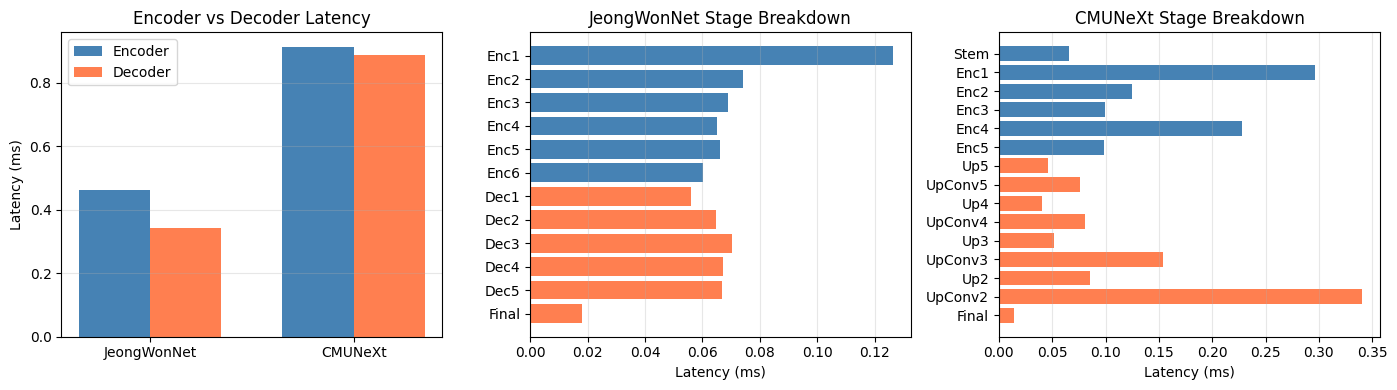

In [6]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Encoder vs Decoder bar chart
ax1 = axes[0]
x_pos = np.arange(2)
width = 0.35
ax1.bar(x_pos - width/2, [jwn_enc_total, cmu_enc_total], width, label='Encoder', color='steelblue')
ax1.bar(x_pos + width/2, [jwn_dec_total, cmu_dec_total], width, label='Decoder', color='coral')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['JeongWonNet', 'CMUNeXt'])
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Encoder vs Decoder Latency')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. JeongWonNet stage breakdown
ax2 = axes[1]
jwn_stages = jwn_enc_keys + jwn_dec_keys
jwn_values = [jwn_results[k]['mean'] for k in jwn_stages]
colors = ['steelblue']*6 + ['coral']*6
ax2.barh(jwn_stages, jwn_values, color=colors)
ax2.set_xlabel('Latency (ms)')
ax2.set_title('JeongWonNet Stage Breakdown')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. CMUNeXt stage breakdown
ax3 = axes[2]
cmu_stages = cmu_enc_keys + cmu_dec_keys
cmu_values = [cmu_results[k]['mean'] for k in cmu_stages]
colors = ['steelblue']*6 + ['coral']*9
ax3.barh(cmu_stages, cmu_values, color=colors)
ax3.set_xlabel('Latency (ms)')
ax3.set_title('CMUNeXt Stage Breakdown')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Enc/Dec ratio comparison
print("="*60)
print("Encoder/Decoder Ratio Analysis")
print("="*60)
print(f"\nJeongWonNet:")
print(f"  Encoder: {jwn_enc_total:.3f} ms ({jwn_enc_total/jwn_total*100:.1f}%)")
print(f"  Decoder: {jwn_dec_total:.3f} ms ({jwn_dec_total/jwn_total*100:.1f}%)")
print(f"  Ratio (Enc/Dec): {jwn_enc_total/jwn_dec_total:.2f}")

print(f"\nCMUNeXt:")
print(f"  Encoder: {cmu_enc_total:.3f} ms ({cmu_enc_total/cmu_total*100:.1f}%)")
print(f"  Decoder: {cmu_dec_total:.3f} ms ({cmu_dec_total/cmu_total*100:.1f}%)")
print(f"  Ratio (Enc/Dec): {cmu_enc_total/cmu_dec_total:.2f}")

print(f"\nConclusion:")
if cmu_dec_total/cmu_total > jwn_dec_total/jwn_total:
    print(f"  CMUNeXt decoder takes {cmu_dec_total/cmu_total*100:.1f}% of total time")
    print(f"  (vs JeongWonNet decoder: {jwn_dec_total/jwn_total*100:.1f}%)")
    print(f"  -> CMUNeXt decoder uses standard conv, causing higher relative latency")

Encoder/Decoder Ratio Analysis

JeongWonNet:
  Encoder: 0.461 ms (57.4%)
  Decoder: 0.343 ms (42.6%)
  Ratio (Enc/Dec): 1.35

CMUNeXt:
  Encoder: 0.912 ms (50.7%)
  Decoder: 0.887 ms (49.3%)
  Ratio (Enc/Dec): 1.03

Conclusion:
  CMUNeXt decoder takes 49.3% of total time
  (vs JeongWonNet decoder: 42.6%)
  -> CMUNeXt decoder uses standard conv, causing higher relative latency
